<a href="https://colab.research.google.com/github/JBregunci/DGMPIA/blob/main/MertonPrelminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD
#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1="tanh", trans2="tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.sigmoid

        # tf.initializers.GlorotUniform()
        # tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_weight("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Ug = self.add_weight("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Ur = self.add_weight("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Uh = self.add_weight("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_weight("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer =tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Wg = self.add_weight("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Wr = self.add_weight("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        self.Wh = self.add_weight("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.initializers.GlorotUniform(),dtype=tf.float32)
        
        # bias vectors
        self.bz = self.add_weight("bz", shape=[1, self.output_dim],dtype=tf.float32)
        self.bg = self.add_weight("bg", shape=[1, self.output_dim],dtype=tf.float32)
        self.br = self.add_weight("br", shape=[1, self.output_dim],dtype=tf.float32)
        self.bh = self.add_weight("bh", shape=[1, self.output_dim],dtype=tf.float32)
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation="tanh"):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_weight("W", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.initializers.GlorotUniform(),dtype=tf.float32)
        
        # bias vectors
        self.b = self.add_weight("b", shape=[1, self.output_dim],dtype=tf.float32)
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
            elif transformation == "sigmoid":
                self.transformation = tf.nn.sigmoid
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None, feedforward=False, output_dim=1):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation="tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.feedforward = feedforward
        self.DGMLayerList = []
                
        for _ in range(self.n_layers):
            if feedforward:
              self.DGMLayerList.append(DenseLayer(layer_width, layer_width))
            else:
              self.DGMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(output_dim, layer_width, transformation=final_trans)
    
    
    # main function to be called  
    def call(self,t,x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t,x],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            if self.feedforward:
                S = self.DGMLayerList[i].call(S)
            else:
                S = self.DGMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result   

In [ ]:
nodes_per_layer = 64
num_layers = 3

sampling_stages  = 50000   # number of times to resample new time-space domain points

# Sample sizes
sample_size = 2**10

batch_size = 2**7
epochs = 2

d = 1
T = 1

t_low = 0 + 1e-10    # time lower bound
Xlow = 0.0 + 1e-10  # wealth lower bound
Xhigh = 1.0         # wealth upper bound
x_multiplier = 1.5

In [ ]:
mu = 0.05
r = 0.02
sigma = 0.25
gamma = 0.5

'''
def sampler(sample_size, d):

    t_interior = np.random.uniform(low=1e-10, high=1, size=(sample_size, 1)).astype(np.float32)
    x_interior = np.random.uniform(low=1e-10, high=1.5, size=(sample_size, d)).astype(np.float32)

    if d > 1:
        t_terminal = np.expand_dims(T * np.ones_like(x_interior[:,1]), 1)
    else:
        t_terminal = T * np.ones_like(x_interior)

    x_terminal = np.random.uniform(low=1e-10, high=1.5, size=(sample_size, d)).astype(np.float32)

    train_dataset = tf.data.Dataset.from_tensor_slices((t_interior, x_interior, t_terminal, x_terminal))
    train_dataset = train_dataset.batch(batch_size)

    return train_dataset
'''

def power_utility(x): 
    ''' Compute exponential utility for given level of wealth
    
    Args:
        x: wealth
    '''
    
    return tf.math.pow(x, gamma)/gamma

def sampler(sample_size):

    t_interior = np.random.uniform(low=t_low, high=T, size=(sample_size, 1)).astype(np.float32)
    x_interior = np.random.uniform(low=Xlow*x_multiplier, high=1.5, size=(sample_size, 1)).astype(np.float32)

    t_terminal = T * np.ones_like(x_interior)
    x_terminal = np.random.uniform(low=Xlow*x_multiplier, high=Xhigh*x_multiplier, size=(sample_size, 1)).astype(np.float32)

    train_dataset = tf.data.Dataset.from_tensor_slices((t_interior, x_interior, t_terminal, x_terminal))
    train_dataset = train_dataset.batch(batch_size)

    return train_dataset

def lossMertonProblem(model):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    '''     
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_interior_tf)
        tape.watch(x_interior_tf)
        V = model(t_interior_tf, x_interior_tf)
        V_s = tape.gradient(V, x_interior_tf)        
    V_t = tape.gradient(V, t_interior_tf)
    V_ss = tape.gradient(V_s, x_interior_tf)

    lambdaMerton = (mu-r)/sigma
    
    #Plugging the numerical substitution back
    #diff_V = (lambdaMerton**2/(2*(1-gamma)))*x_interior_tf**2*V_ss + x_interior_tf*V_s*(lambdaMerton**2/(1-gamma) + r)
    
    #Plugging the partial derivative control from
    diff_V = -(lambdaMerton**2/2)*(tf.math.pow(V_s,2)) + (V_t+r*x_interior_tf*V_s)*V_ss

    L1 = tf.reduce_mean(tf.square(diff_V))
    target_payoff = power_utility(x_terminal_tf)
    fitted_payoff = model(t_terminal_tf, x_terminal_tf)
    
    L2 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return L1, L2

@tf.function
def trainStepMertonProblem():
    with tf.GradientTape() as tape:

        # Compute the loss value for this minibatch.
        L1, L2 = lossMertonProblem(model)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(L1 + L2, model.trainable_variables)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return L1, L2

In [ ]:
t_interior, x_interior, t_terminal, x_terminal = list(enumerate(sampler(sample_size) ))[0][1] 
t_interior_tf = tf.Variable(t_interior, trainable=False)
x_interior_tf = tf.Variable(x_interior, trainable=False)
t_terminal_tf = tf.Variable(t_terminal, trainable=False)
x_terminal_tf = tf.Variable(x_terminal, trainable=False)
step = tf.Variable(0.0, trainable=False)

model = DGMNet(nodes_per_layer, num_layers, d)

# learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     [50, 200, 2e4, 3e4, 4e4, 4.5e4],
#     [1e-2, 1e-3, 1e-4, 5e-5, 1e-6, 5e-6, 1e-7]
#     )

alpha = 1e-4

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [5e3, 1e4, 2e4, 3e4, 4e4, 4.5e4],
    [10*alpha, 5*alpha, alpha, 5e-1 * alpha, 1e-1 * alpha, 5e-2 * alpha, 1e-2 * alpha]
    )

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()#, nesterov=True)

In [ ]:
for s in range(sampling_stages+1):

    train_dataset = sampler(sample_size) 

    for epoch in range(epochs):

        start = time.time()

        for _, (t_interior, x_interior, t_terminal, x_terminal) in enumerate(train_dataset):

            t_interior_tf.assign(t_interior)
            x_interior_tf.assign(x_interior)
            t_terminal_tf.assign(t_terminal)
            x_terminal_tf.assign(x_terminal)
            step.assign(s)

            optimizer.lr.assign(learning_rate_fn(step))

            loss_diff, loss_terminal = trainStepMertonProblem()


        end = time.time()

    if s % 200 == 0:
        print(
            "Training loss of value func at step %d: L_diff: %.4e, L_terminal: %.4e"
            % (s, float(loss_diff), float(loss_terminal))
        )

        #print("Step: %s" % s)
        #print("Seen so far: %s samples" % ((s + 1) * s_x_interior))
        print("Time: %.2f" % (end - start))
        print("-----------")
        #print('Learning rate:  %.2e' % optimizer.learning_rate.numpy())

        model.save_weights('Merton_price_' + str(d) + '.h5')

FailedPreconditionError: ignored

In [ ]:
model = DGMNet(nodes_per_layer, num_layers, 1)
model.built = True
model.load_weights('Merton_price_1.h5')

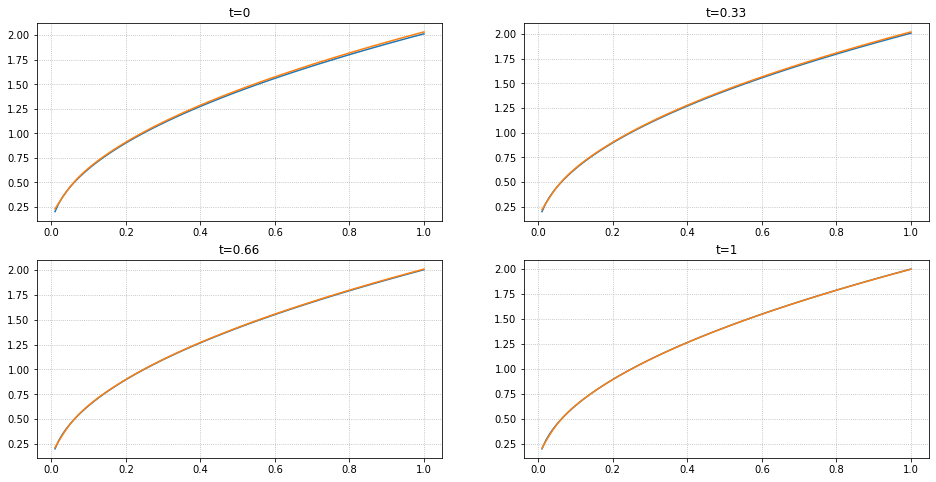

In [ ]:
def MertonProblem(S,mu,r,sigma,t,gamma):
    ''' Analytical solution for Merton prolem with power utility
    
    Args:
        mu:     drift risky asset
        r:     risk-free interest rate
        sigma: volatility risky asset
        t:     current time
    ''' 
    return (1/gamma)*np.exp(((mu-r)**2*gamma)/(2*sigma**2*(1-gamma))*(T-t))*S**gamma

n_plot = np.linspace(1e-2,1,100)
n_plot_s = n_plot[1]-n_plot[0]


# Calculation optimal control from derivatives with backward and central differences
def control_from(lis):
  sols = [0]*(len(lis)-2)
  for i in range(1,len(lis)-1):
    sols[i-1] = ((-(mu-r)*(lis[i]-lis[i-1]))/n_plot_s)/(sigma**2*n_plot[i]*((lis[i-1]-2*lis[i]+lis[i+1]))/n_plot_s**2 )
  return sols

def valueCurveDisplay():
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))

  analyticSol = [MertonProblem(x,mu,r,sigma,0,gamma) for x in n_plot]
  resultNN = model(0 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax1.plot(n_plot, analyticSol)
  ax1.grid(True,linestyle='dotted')
  ax1.plot(n_plot, resultNN)
  ax1.title.set_text('t=0')

  analyticSol = [MertonProblem(x,mu,r,sigma,0.33,gamma) for x in n_plot]
  resultNN = model(0.33 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax2.plot(n_plot, analyticSol)
  ax2.grid(True,linestyle='dotted')
  ax2.plot(n_plot, resultNN)
  ax2.title.set_text('t=0.33')

  analyticSol = [MertonProblem(x,mu,r,sigma,0.66,gamma) for x in n_plot]
  resultNN = model(0.66 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax3.plot(n_plot, analyticSol)
  ax3.grid(True,linestyle='dotted')
  ax3.plot(n_plot, resultNN)
  ax3.title.set_text('t=0.66')

  analyticSol = [MertonProblem(x,mu,r,sigma,1,gamma) for x in n_plot]
  resultNN = model(1 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax4.plot(n_plot, analyticSol)
  ax4.grid(True,linestyle='dotted')
  ax4.plot(n_plot, resultNN)
  ax4.title.set_text('t=1')

def controlDisplay():
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))

  analyticSol = [MertonProblem(x,mu,r,sigma,0,gamma) for x in n_plot]
  resultNN = model(0 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax1.plot(n_plot[1:-1], control_from(analyticSol))
  ax1.grid(True,linestyle='dotted')
  ax1.plot(n_plot[1:-1], control_from(resultNN))
  ax1.title.set_text('t=0')
  ax1.set_ylim([0,5])

  analyticSol = [MertonProblem(x,mu,r,sigma,0.33,gamma) for x in n_plot]
  resultNN = model(0.33 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax2.plot(n_plot[1:-1], control_from(analyticSol))
  ax2.grid(True,linestyle='dotted')
  ax2.plot(n_plot[1:-1], control_from(resultNN))
  ax2.title.set_text('t=0.33')
  ax2.set_ylim([0,5])

  analyticSol = [MertonProblem(x,mu,r,sigma,0.66,gamma) for x in n_plot]
  resultNN = model(0.66 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax3.plot(n_plot[1:-1], control_from(analyticSol))
  ax3.grid(True,linestyle='dotted')
  ax3.plot(n_plot[1:-1], control_from(resultNN))
  ax3.title.set_text('t=0.66')
  ax3.set_ylim([0,5])

  analyticSol = [MertonProblem(x,mu,r,sigma,1,gamma) for x in n_plot]
  resultNN = model(1 * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1))

  ax4.plot(n_plot[1:-1], control_from(analyticSol))
  ax4.grid(True,linestyle='dotted')
  ax4.plot(n_plot[1:-1], control_from(resultNN))
  ax4.title.set_text('t=1')
  ax4.set_ylim([0,5])

def heatmapDisplay():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

  vals = np.zeros((len(n_plot),len(n_plot)))
  for i, t in enumerate(n_plot):
    vals[i] = np.array([MertonProblem(x,mu,r,sigma,t,gamma) for x in n_plot])
    vals[i] = np.abs(vals[i]-model(t * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1)).numpy().reshape(-1))
    #np.abs(np.array([MertonProblem(x,mu,r,sigma,t,gamma) for x in S_plot])-model(np.ones_like(S_plot.reshape(-1,1))*t,S_plot.reshape(-1,1))).reshape(-1,1)

  vals = pd.DataFrame(vals, columns=[round(x,1) for x in list(n_plot)], index=[round(x,1) for x in list(n_plot)])
  ax1 = sns.heatmap(vals, cmap="rocket", xticklabels=6, yticklabels=6)
  ax1.invert_yaxis()
  ax1.set_xlabel("x") 
  ax1.set_ylabel("t") 
  ax1.set_title("Absolute Error")
  ax1.plot()

  plt.subplot(1,2,1)

  vals = np.zeros((len(n_plot),len(n_plot)))
  for i, t in enumerate(n_plot):
    vals[i] = np.array([MertonProblem(x,mu,r,sigma,t,gamma) for x in n_plot])
    vals[i] = np.abs(1-model(t * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1)).numpy().reshape(-1)/vals[i])

  vals = pd.DataFrame(vals, columns=[round(x,1) for x in list(n_plot)], index=[round(x,1) for x in list(n_plot)])
  ax2 = sns.heatmap(vals, cmap="rocket", xticklabels=6, yticklabels=6)
  ax2.invert_yaxis()
  ax2.set_xlabel("x") 
  ax2.set_ylabel("t") 
  ax2.set_title("Relative Error")
  ax2.plot()

def heatmapContDisplay():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

  vals = np.zeros((len(n_plot)-2,len(n_plot)-2))
  for i, t in enumerate(n_plot[1:-1]):
    vals[i] = np.array(control_from([MertonProblem(x,mu,r,sigma,t,gamma) for x in n_plot]))
    vals[i] = np.abs(vals[i]-control_from(model(t * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1)).numpy().reshape(-1)))
    #np.abs(np.array([MertonProblem(x,mu,r,sigma,t,gamma) for x in S_plot])-model(np.ones_like(S_plot.reshape(-1,1))*t,S_plot.reshape(-1,1))).reshape(-1,1)

  vals = pd.DataFrame(vals, columns=[round(x,1) for x in list(n_plot[1:-1])], index=[round(x,1) for x in list(n_plot[1:-1])])
  ax1 = sns.heatmap(vals, cmap="rocket", xticklabels=6, yticklabels=6)
  ax1.invert_yaxis()
  ax1.set_xlabel("x") 
  ax1.set_ylabel("t") 
  ax1.set_title("Absolute Error")
  ax1.plot()

  plt.subplot(1,2,1)

  vals = np.zeros((len(n_plot)-2,len(n_plot)-2))
  for i, t in enumerate(n_plot[1:-1]):
    vals[i] = np.array(control_from([MertonProblem(x,mu,r,sigma,t,gamma) for x in n_plot]))
    vals[i] = np.abs(1-((control_from(model(t * np.ones_like(n_plot.reshape(-1,1)), n_plot.reshape(-1,1)).numpy().reshape(-1)))/vals[i] ))

  vals = pd.DataFrame(vals, columns=[round(x,1) for x in list(n_plot[1:-1])], index=[round(x,1) for x in list(n_plot[1:-1])])
  ax2 = sns.heatmap(vals, cmap="rocket", xticklabels=6, yticklabels=6)
  ax2.invert_yaxis()
  ax2.set_xlabel("x") 
  ax2.set_ylabel("t") 
  ax2.set_title("Relative Error")
  ax2.plot()


valueCurveDisplay()

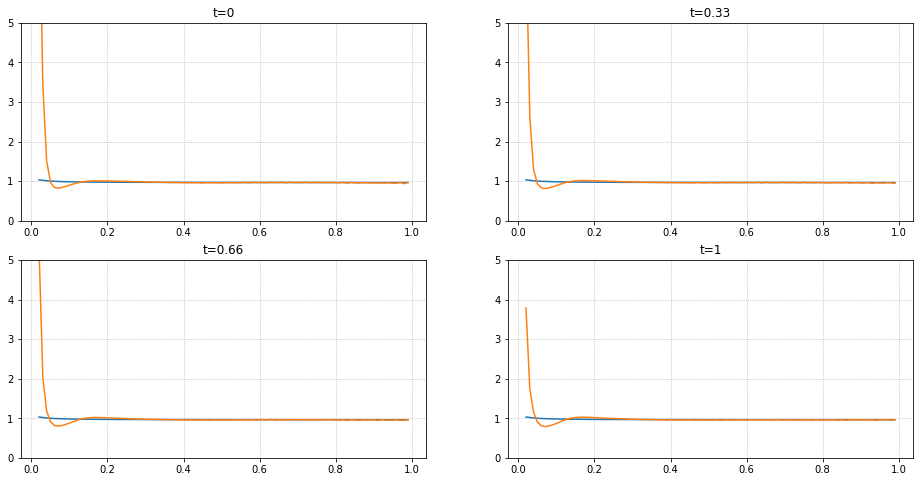

In [ ]:
controlDisplay()

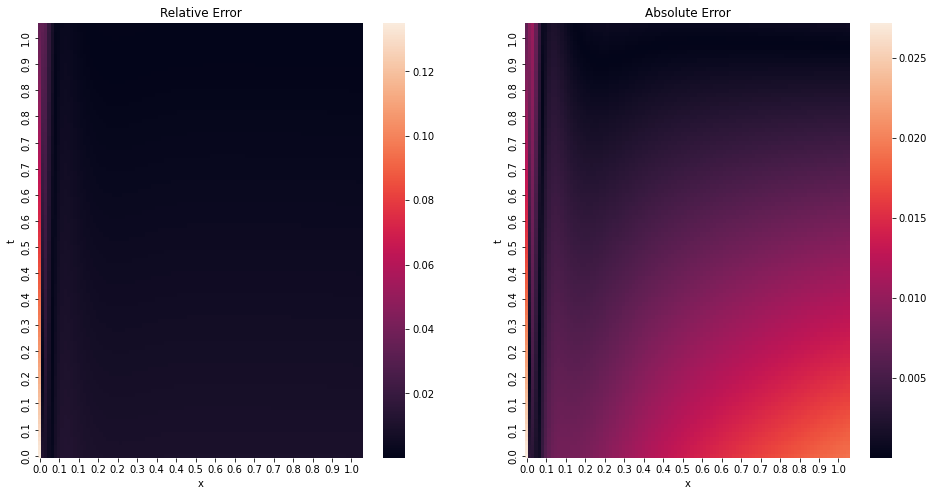

In [ ]:
heatmapDisplay()

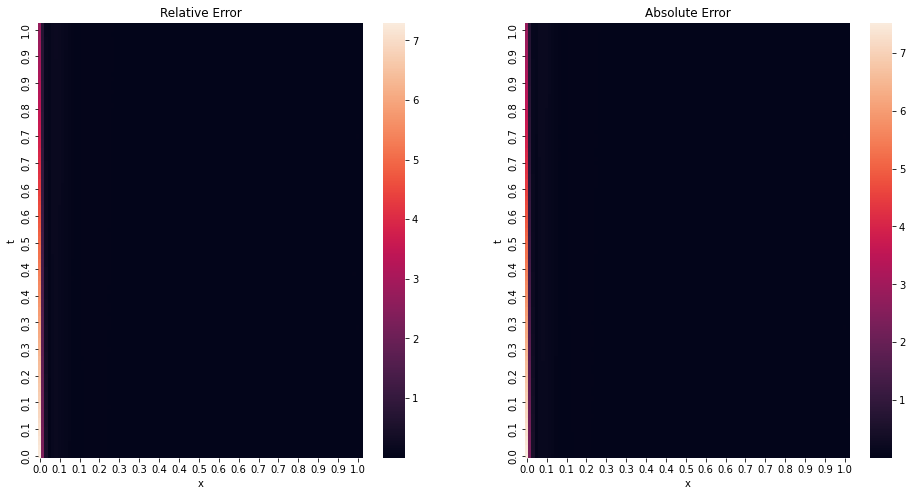

In [ ]:
heatmapContDisplay()